In [ ]:
#!pip install tensorflow opencv-python matplotlib

In [2]:
import tensorflow as tf
import os
import tensorflow_hub as hub
import tensorflow_addons as tfa


C:\Users\s1093370\AppData\Local\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
data_dir = r"BingMaps Test Images"
#os.listdir(os.path.join(data_dir, 'Negative'))

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import string
import unicodedata

In [15]:
#because there were special characters in our file names
def remove_special_characters(text):
    # Remove diacritic marks from the text
    text = unicodedata.normalize('NFD', text)
    # Filter out characters that are not in the ASCII range or not in the allowed set of special characters
    filtered_text = ''.join(c for c in text if (ord(c) < 128) or (c in string.punctuation + string.ascii_letters + string.digits))
    # Remove whitespace and return the modified text
    return filtered_text.strip()

def rename_files_in_directory(directory):
    for filename in os.listdir(directory):
        # Check if the filename has any special characters
        if not filename.isascii():
            new_filename = remove_special_characters(filename)
            new_filename = f"{new_filename}_FIXED"
            if not new_filename in os.listdir(directory):
                old_filepath = os.path.join(directory, filename)
                new_filepath = os.path.join(directory, new_filename)
                # Rename the file
                os.rename(old_filepath, new_filepath)
                print(f"Renamed {filename} to {new_filename}")

# Specify the directory path where your image dataset is located

dataset_directory = r"C:\Users\ohits\OneDrive\Renewables CNN\BingMaps Test Images\Positive"
#dataset_directory = r'C:\Users\s1093370\OneDrive\Renewables CNN\BingMaps Test Images'

# Call the function to rename files in the specified directory
rename_files_in_directory(dataset_directory)

In [20]:
#building data pieline

directory = r'C:\Users\ohits\OneDrive\Renewables CNN\BingMaps Test Images'
data = tf.keras.utils.image_dataset_from_directory(directory)
#accessing the data pipeline
data_iterator = data.as_numpy_iterator()

#images represented as numpy array
batch = data_iterator.next()

Found 884 files belonging to 2 classes.


In [21]:
batch[0].shape #batch size of 32

(32, 256, 256, 3)

In [23]:
#scale data for efficiency

data = data.map(lambda x,y: (x/255,y))

## Adding Data Augmentation!


In [11]:
train_size = int(len(data)*.7) #70% training
val_size = int(len(data)*.2)+1 #20% validation
test_size = int(len(data)*.1)+1 #10% testing

#added one so that these all sum up to the length of our data (because i think python rounds down here)

In [12]:
#this works because our data has been shuffled!
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE
train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE)

## Build the Network

In [17]:
from tensorflow.keras.models import Sequential

#These are the layers of our model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [18]:
model = Sequential()

In [19]:
### LAYER ONE ###

# 16 filters, kernel size 3x3, stride 1
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

### LAYER TWO ###
model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

## lAYER THREE ###
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

## LAYER FOUR ##
model.add(Flatten())

## LAYERS FIVE AND SIX ##
#Fully connected layers
model.add(Dense(256, activation='relu')) # 256 Neurons
model.add(Dense(1, activation='sigmoid')) #1D output


In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

#When parameters are 0, these are NON trainable layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

### Training Time

In [21]:
# Here we're logging the training of model in a place we can access it locally later
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [22]:
#model.fit is the command that actually starts training
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
19/19 [==============================] - 12s 565ms/step - loss: 0.6708 - accuracy: 0.6546 - val_loss: 0.7399 - val_accuracy: 0.6823
Epoch 2/20
19/19 [==============================] - 11s 549ms/step - loss: 0.3148 - accuracy: 0.8701 - val_loss: 0.6204 - val_accuracy: 0.7448
Epoch 3/20
19/19 [==============================] - 11s 544ms/step - loss: 0.2685 - accuracy: 0.8865 - val_loss: 0.2563 - val_accuracy: 0.9167
Epoch 4/20
19/19 [==============================] - 11s 571ms/step - loss: 0.1914 - accuracy: 0.9293 - val_loss: 0.2787 - val_accuracy: 0.9010
Epoch 5/20
19/19 [==============================] - 11s 550ms/step - loss: 0.1438 - accuracy: 0.9424 - val_loss: 0.1923 - val_accuracy: 0.9271
Epoch 6/20
19/19 [==============================] - 12s 583ms/step - loss: 0.1621 - accuracy: 0.9457 - val_loss: 0.1372 - val_accuracy: 0.9635
Epoch 7/20
19/19 [==============================] - 11s 554ms/step - loss: 0.1356 - accuracy: 0.9474 - val_loss: 0.1147 - val_accuracy: 0.9792

## Plot Perfromance

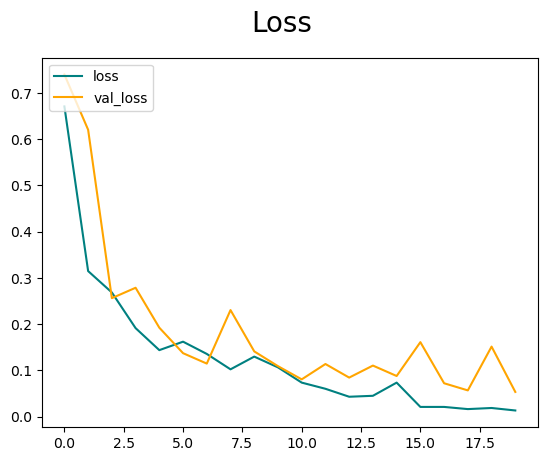

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

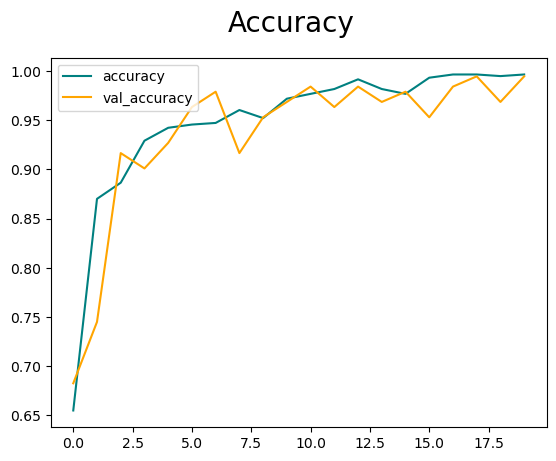

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 0s 59ms/step


In [28]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:1.0, Recall: 0.9736841917037964, Accuracy: 0.9848484992980957


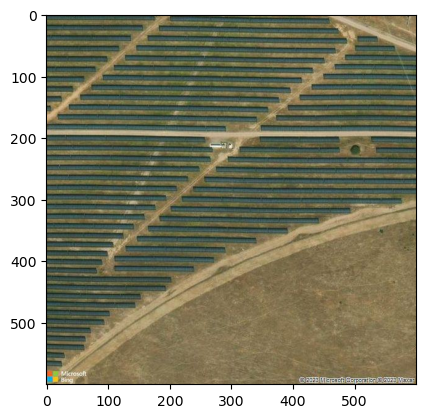

In [69]:
#Testing this on some unseen data
img1 = cv2.imread(r'C:\Users\s1093370\OneDrive\Renewables CNN\BingMaps Test Images\positive_Portugal_Ourika Solar.jpg')
img2 = cv2.imread(r'C:\Users\s1093370\OneDrive\Renewables CNN\BingMaps Test Images\negative_Russia_Chernovskaya solar farm.jpg')
img3 = cv2.imread(r'C:\Users\s1093370\OneDrive\Renewables CNN\BingMaps Test Images\positive_Portugal_Hercules solar farm.jpg')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

In [66]:
#Convert image into something that can be passed by the model

def execute_model(img):
    #make our image something the model can read
    resized = tf.image.resize(img, (256, 256))
    scaled = resized/255
    #this is to get our image into the format (batch size, 256, 256, 3) where batch size is 1
    #right now our image is in the format (256, 256, 3)
    as_batch = np.expand_dims(scaled, 0)
    
    #execute the model
    yhat = model.predict(as_batch)
    
    if yhat > 0.5:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.suptitle('Solar field detected!', fontsize=15)
        plt.title(f'Actual prediciton value: {yhat[0][0]}', fontsize=10)
        plt.show()
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.suptitle('No solar field detected', fontsize=15)
        plt.title(f'Actual prediciton value: {yhat[0][0]}', fontsize=10)
        plt.show()
    
    return yhat



1/1 [==============================] - 0s 26ms/step


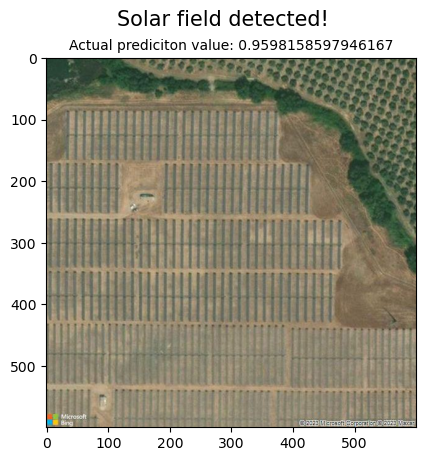

In [70]:
prediction = execute_model(img3)

## Save the model

In [29]:
from tensorflow.keras.models import load_model

In [30]:
model.save(os.path.join('models', 'solar_field_classifier_data_aug.h5'))

#to reload it we would do:

#new_model = load_model('solar_field_classifier.h5')